# Content

- [Aims](#Aims)
- [Helper Functions](#Helper-Functions)
- [Data Description](#Data-Description)
- [Import Data](#Import-Data)
- [Data Preprocessing](#Data-Preprocessing)
- [Data Splitting](#Data-Splitting)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_ks_statistic

import warnings
warnings.filterwarnings('ignore')

# Aims

- To find out what factors are significant to the win rate.
- To analyze how the significant factors affect the win rate.

# Helper Functions

In [2]:
def forward_selection(X, y, alpha = 0.05):
    logit = sm.GLM(y, np.ones(len(X)), family = sm.families.Binomial()).fit()
    prev_deviance = logit.deviance
        
    selected_list = []
    remaining_list = X.columns.tolist().copy()
    selected = None
    p_value = None
    for i in range(X.shape[1]):
        deviance_min = np.inf
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
            if deviance_min > logit.deviance:
                deviance_min = logit.deviance
                selected = col
        
        test_statistic = 2*(prev_deviance - deviance_min)
        p_value = stats.chi2.sf(test_statistic, df = 1)

        if p_value < alpha:
            selected_list.append(selected)
            remaining_list.remove(selected)
            prev_deviance = deviance_min
                
        else:
            return selected_list

In [3]:
def backward_elimination(X, y, alpha = 0.10):
    logit = sm.GLM(y, sm.add_constant(X), family = sm.families.Binomial()).fit()
    prev_deviance = logit.deviance
        
    remaining_list = X.columns.tolist().copy()
    removed = None
    p_value = None
    for i in range(X.shape[1]):
        deviance_min = np.inf
        for col in remaining_list:
            cols = remaining_list.copy()
            cols.remove(col)
            logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
            if deviance_min > logit.deviance:
                deviance_min = logit.deviance
                removed = col
            
        test_statistic = 2*(deviance_min - prev_deviance)
        p_value = stats.chi2.sf(test_statistic, df = 1)

        if p_value >= alpha:
            remaining_list.remove(removed)
            prev_deviance = deviance_min
                
        else:
            return remaining_list

In [4]:
def stepwise_regression(X, y, alpha_in = 0.05, alpha_out = 0.10):
    logit = sm.GLM(y, np.ones(len(X)), family = sm.families.Binomial()).fit()
    prev_deviance = logit.deviance
        
    remaining_list = X.columns.tolist().copy()
    selected_list = []
    selected = None
    removed = None
    p_value_in = None
    p_value_out = None
      
    while len(remaining_list) != 0:
        deviance_min = np.inf
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            
            logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
            
            if deviance_min > logit.deviance:
                selected = col
                deviance_min = logit.deviance
                
        test_statistic = 2*(prev_deviance - deviance_min)
        p_value = stats.chi2.sf(test_statistic, df = 1)
        
        
        if p_value < alpha_in:
            selected_list.append(selected)
            remaining_list.remove(selected)
            prev_deviance = deviance_min
                
        else:
            return selected_list
        
        deviance_min = np.inf
        for col in selected_list:
            cols = selected_list.copy()
            cols.remove(col)
            
            if len(cols) == 0:
                logit = sm.GLM(y, np.ones(len(X)), family = sm.families.Binomial()).fit()
            else:
                logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
                
            if deviance_min > logit.deviance:
                removed = col
                deviance_min = logit.deviance
        
        test_statistic = 2*(deviance_min - prev_deviance)
        p_value = stats.chi2.sf(test_statistic, df = 1)        
        
        if p_value >= alpha_out:
            selected_list.remove(removed)
            remaining_list.append(removed)
            prev_deviance = deviance_min

# Data Description

The data is crawled on 12-02-2021. The data is the match history of 5,014 unrank Summoner's Rift matches in NA server from 05-02-2021 to 12-02-2021.

- Side: The side of the team (Blue / Red)
- Win: Whether the team won (1: Yes/ 0: No)
- First_Blood: Whether the team got the first blood (1: Yes/ 0: No)
- First_Tower: Whether the team got the first tower (1: Yes/ 0: No)
- First_Inhibitor: Whether the team got the first inhibitor (1: Yes/ 0: No)
- First_Baron: Whether the team got the first Baron (1: Yes/ 0: No)
- First_Dragon: Whether the team got the first Dragon (1: Yes/ 0: No)
- First_Rift_Herald: Whether the team got the first Rift Herald (1: Yes/ 0: No)
- Tower_Destroyed: Number of towers the team destroyed
- Inhibitor_Destroyed: Number of inhibitors the team destroyed
- Baron_Killed: Number of Baron the team killed
- Dragon_Killed: Number of Dragon the team killed
- Vilemaw_Killed: Number of Vilemaw the team killed
- Rift_Herald_Killed: Number of Vilemaw the team killed
- Game_Duration: Game Duration (in second)
- Total_Kills: Number of kills of the team
- Total_Deaths: Number of deaths of the team
- Total_Assists: Number of assists of the team
- Total_Magic_Damage_Dealt: Total amount of magic damage the team dealt
- Total_Physical_Damage_Dealt: Total amount of physical damage the team dealt
- Total_True_Damage_Dealt: Total amount of true damage the team dealt
- Total_Magic_Damage_To_Champions: Total amount of magic damage the team dealt to opposite champions
- Total_Physical_Damage_To_Champions: Total amount of physical damage the team dealt to opposite champions
- Total_True_Damage_To_Champions: Total amount of true damage the team dealt to opposite champions
- Total_Heal: Total amount of HP the team healed
- Total_Damage_Self_Mitigated: Total amount of damage self mitigated of the team
- Total_Damage_Dealt_To_Objectives: Total amount of damage the team dealt to objectives
- Total_Damage_Dealt_To_Turrets: Total amount of damage the team dealt to turrets
- Total_Vision_Score: Total vision score
- Total_Time_CCing_Others: Total time of the team crowd-controling (CCing) opposite team (in second)
- Total_Magical_Damage_Taken: Total amount of magic damage the team took
- Total_Physical_Damage_Taken: Total amount of physical damage the team took
- Total_True_Damage_Taken: Total amount of true damage the team took
- Total_Gold_Earned: Total amount of gold the team earned
- Total_Minions_Killed: Total number of minions the team killed
- Total_Neutral_Minions_Killed: Total number of neutral minions the team killed
- Total_Neutral_Minions_Killed_Team_Jungle: Total number of neutral minions in the team's jungle the team killed
- Total_Neutral_Minions_Killed_Enemy_Jungle: Total number of neutral minions in the enemy's jungle the team killed
- Total_Time_Crowd_Control_Dealt: Total time of crowd-control the team dealt (in second)
- Total_Champion_Level: The sum of the levels of the champions in the team.

# Import Data

In [5]:
data = pd.read_csv('../../data/LOL/lol_matches.csv')
data.shape

(10028, 40)

In [6]:
data.head()

,Side,Win,First_Blood,First_Tower,First_Inhibitor,First_Baron,First_Dragon,First_Rift_Herald,Tower_Destroyed,Inhibitor_Destroyed,...,Total_Magical_Damage_Taken,Total_Physical_Damage_Taken,Total_True_Damage_Taken,Total_Gold_Earned,Total_Minions_Killed,Total_Neutral_Minions_Killed,Total_Neutral_Minions_Killed_Team_Jungle,Total_Neutral_Minions_Killed_Enemy_Jungle,Total_Time_Crowd_Control_Dealt,Total_Champion_Level
0,Blue,1,1,1,0,0,1,0,3,0,...,17957,24170,2918,33464,371,112,44,48,409,52
1,Red,0,0,0,0,0,0,0,0,0,...,11373,24629,3072,22981,234,0,0,0,312,43
2,Blue,1,1,0,1,1,0,0,10,2,...,47291,91322,14940,72312,745,205,149,16,850,84
3,Red,0,0,1,0,0,1,1,10,2,...,30115,105230,18267,71655,709,194,103,40,1617,73
4,Blue,1,1,0,0,1,0,0,5,0,...,19756,47415,4319,47929,560,137,93,4,636,68


# Data Preprocessing

In [7]:
data['Blue'] = [1 if x == 'Blue' else 0 for x in data['Side']]
data = data.drop('Side', axis = 1)
data.head()

,Win,First_Blood,First_Tower,First_Inhibitor,First_Baron,First_Dragon,First_Rift_Herald,Tower_Destroyed,Inhibitor_Destroyed,Baron_Killed,...,Total_Physical_Damage_Taken,Total_True_Damage_Taken,Total_Gold_Earned,Total_Minions_Killed,Total_Neutral_Minions_Killed,Total_Neutral_Minions_Killed_Team_Jungle,Total_Neutral_Minions_Killed_Enemy_Jungle,Total_Time_Crowd_Control_Dealt,Total_Champion_Level,Blue
0,1,1,1,0,0,1,0,3,0,0,...,24170,2918,33464,371,112,44,48,409,52,1
1,0,0,0,0,0,0,0,0,0,0,...,24629,3072,22981,234,0,0,0,312,43,0
2,1,1,0,1,1,0,0,10,2,1,...,91322,14940,72312,745,205,149,16,850,84,1
3,0,0,1,0,0,1,1,10,2,0,...,105230,18267,71655,709,194,103,40,1617,73,0
4,1,1,0,0,1,0,0,5,0,1,...,47415,4319,47929,560,137,93,4,636,68,1


In [8]:
data['Vilemaw_Killed'].value_counts()
# In the sample, none of the teams killed Vilemaw.

0    10028
Name: Vilemaw_Killed, dtype: int64

In [9]:
data = data.drop('Vilemaw_Killed', axis = 1)
data.head()

,Win,First_Blood,First_Tower,First_Inhibitor,First_Baron,First_Dragon,First_Rift_Herald,Tower_Destroyed,Inhibitor_Destroyed,Baron_Killed,...,Total_Physical_Damage_Taken,Total_True_Damage_Taken,Total_Gold_Earned,Total_Minions_Killed,Total_Neutral_Minions_Killed,Total_Neutral_Minions_Killed_Team_Jungle,Total_Neutral_Minions_Killed_Enemy_Jungle,Total_Time_Crowd_Control_Dealt,Total_Champion_Level,Blue
0,1,1,1,0,0,1,0,3,0,0,...,24170,2918,33464,371,112,44,48,409,52,1
1,0,0,0,0,0,0,0,0,0,0,...,24629,3072,22981,234,0,0,0,312,43,0
2,1,1,0,1,1,0,0,10,2,1,...,91322,14940,72312,745,205,149,16,850,84,1
3,0,0,1,0,0,1,1,10,2,0,...,105230,18267,71655,709,194,103,40,1617,73,0
4,1,1,0,0,1,0,0,5,0,1,...,47415,4319,47929,560,137,93,4,636,68,1


# Data Splitting

In [10]:
train, test = train_test_split(data, test_size = 0.2, random_state = 0)
train.shape, test.shape

((8022, 39), (2006, 39))

In [11]:
train, validate = train_test_split(train, test_size = 0.1, random_state = 0)
train.shape, validate.shape

((7219, 39), (803, 39))

# Models

## Full Model

In [12]:
X = train.drop('Win', axis = 1)
y = train['Win']

In [13]:
full_model = sm.GLM(y, sm.add_constant(X), family = sm.families.Binomial()).fit()
full_model.summary()
# First_Blood, First_Inhibitor, First_Baron

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7180
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -826.19
Date:                Sun, 14 Feb 2021   Deviance:                       1652.4
Time:                        21:25:41   Pearson chi2:                 2.48e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.4060      0.283     -4.973      0.000      -1.960      -0.852
First_Blood                                  -0.0594      0.133     -0.446      0.656      -0.320       0.202
First_Tower                                   0.4523      0.151      2.998      0.003       0.157       0.748
First_Inhibitor                              -0.1801      0.219     -0.821      0.412      -0.610       0.250
First_Baron                                  -0.6821      0.303     -2.253      0.024      -1.275      -0.089
First_Dragon                                 -0.3018      0.166     -1.816      0.069      -0.627       0.024
First_Rift_Herald                             0.4940      0.330      1.499      0.134      -0.152       1.140
Tower_Destroyed                               0.6219      0.081      7.642      0.000       0.462       0.781
Inhibitor_Destroyed                           0.7686      0.115      6.657      0.000       0.542       0.995
Baron_Killed                                  0.8681      0.303      2.861      0.004       0.273       1.463
Dragon_Killed                                 0.4180      0.113      3.706      0.000       0.197       0.639
Rift_Herald_Killed                           -0.4164      0.300     -1.387      0.165      -1.005       0.172
Game_Duration                                -0.0102      0.001    -12.515      0.000      -0.012      -0.009
Total_Kills                                  -0.0287      0.021     -1.364      0.172      -0.070       0.013
Total_Deaths                                 -0.2478      0.016    -15.836      0.000      -0.278      -0.217
Total_Assists                                 0.0061      0.008      0.786      0.432      -0.009       0.021
Total_Magic_Damage_Dealt                   2.696e-06   2.21e-06      1.217      0.223   -1.64e-06    7.04e-06
Total_Physical_Damage_Dealt                 3.55e-06   1.97e-06      1.806      0.071   -3.02e-07     7.4e-06
Total_True_Damage_Dealt                    -9.48e-07   2.37e-06     -0.399      0.690    -5.6e-06     3.7e-06
Total_Magic_Damage_To_Champions            3.551e-05   8.71e-06      4.078      0.000    1.84e-05    5.26e-05
Total_Physical_Damage_To_Champions         1.383e-05   8.44e-06      1.638      0.101   -2.72e-06    3.04e-05
Total_True_Damage_To_Champions             4.329e-05   1.92e-05      2.260      0.024    5.75e-06    8.08e-05
Total_Heal                                 2.861e-05      9e-06      3.180      0.001     1.1e-05    4.62e-05
Total_Damage_Self_Mitigated                3.844e-06   3.59e-06      1.071      0.284   -3.19e-06    1.09e-05
Total_Damage_Dealt_To_Objectives          -8.569e-06   1.17e-05     -0.734      0.463   -3.14e-05    1.43e-05
Tot

In [14]:
critical_value = stats.chi2.ppf(0.95, df=full_model.df_resid)
p_value = stats.chi2.sf(full_model.deviance, df=full_model.df_resid)

print('Test statistic:', full_model.deviance)
print('Critical value:', critical_value)
print('p-value:', p_value)
# The lack of fit problem is not significant.

Test statistic: 1652.3840015604662
Critical value: 7378.238564677696
p-value: 1.0


## Forward Selection

In [15]:
forward_features = forward_selection(X, y)
forward_features

['Tower_Destroyed',
 'Total_Deaths',
 'Total_Kills',
 'Game_Duration',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Champion_Level',
 'Inhibitor_Destroyed',
 'Total_Neutral_Minions_Killed',
 'Dragon_Killed',
 'Total_Magic_Damage_To_Champions',
 'Total_Time_CCing_Others',
 'Total_Vision_Score',
 'Total_Physical_Damage_To_Champions',
 'Total_Physical_Damage_Taken',
 'Total_Magical_Damage_Taken',
 'Total_Heal',
 'First_Tower',
 'Baron_Killed',
 'First_Baron',
 'Total_True_Damage_To_Champions',
 'First_Dragon',
 'Total_Damage_Dealt_To_Turrets',
 'Total_True_Damage_Taken']

In [16]:
forward_model = sm.GLM(y, sm.add_constant(X[forward_features]), family = sm.families.Binomial()).fit()
forward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7194
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -832.55
Date:                Sun, 14 Feb 2021   Deviance:                       1665.1
Time:                        21:26:08   Pearson chi2:                 4.37e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.4192      0.262     -5.425      0.000      -1.932      -0.906
Tower_Destroyed                        0.5835      0.076      7.695      0.000       0.435       0.732
Total_Deaths                          -0.2574      0.014    -17.782      0.000      -0.286      -0.229
Total_Kills                           -0.0394      0.020     -1.937      0.053      -0.079       0.000
Game_Duration                         -0.0101      0.001    -13.263      0.000      -0.012      -0.009
Total_Gold_Earned                      0.0004   4.63e-05      9.448      0.000       0.000       0.001
Total_Minions_Killed                  -0.0122      0.002     -7.318      0.000      -0.015      -0.009
Total_Champion_Level                   0.1754      0.019      9.383      0.000       0.139       0.212
Inhibitor_Destroyed                    0.7298      0.102      7.161      0.000       0.530       0.930
Total_Neutral_Minions_Killed          -0.0139      0.002     -5.789      0.000      -0.019      -0.009
Dragon_Killed                          0.4215      0.082      5.149      0.000       0.261       0.582
Total_Magic_Damage_To_Champions      4.07e-05   6.04e-06      6.739      0.000    2.89e-05    5.25e-05
Total_Time_CCing_Others               -0.0065      0.002     -3.898      0.000      -0.010      -0.003
Total_Vision_Score                    -0.0110      0.003     -3.915      0.000      -0.017      -0.005
Total_Physical_Damage_To_Champions  2.347e-05   6.69e-06      3.509      0.000    1.04e-05    3.66e-05
Total_Physical_Damage_Taken        -3.998e-05   7.02e-06     -5.692      0.000   -5.37e-05   -2.62e-05
Total_Magical_Damage_Taken         -3.552e-05    6.9e-06     -5.145      0.000   -4.91e-05    -2.2e-05
Total_Heal                          2.438e-05   8.57e-06      2.846      0.004    7.59e-06    4.12e-05
First_Tower                            0.4064      0.144      2.818      0.005       0.124       0.689
Baron_Killed                           0.8092      0.248      3.262      0.001       0.323       1.295
First_Baron                           -0.6880      0.296     -2.327      0.020      -1.267      -0.109
Total_True_Damage_To_Champions      3.675e-05   1.82e-05      2.019      0.043    1.08e-06    7.24e-05
First_Dragon                          -0.2810      0.162     -1.734      0.083      -0.599       0.037
Total_Damage_Dealt_To_Turrets      -4.025e-05   2.49e-05     -1.618      0.106    -8.9e-05     8.5e-06
Total_True_Damage_Taken            -2.488e-05   1.67e-05     -1.487      0.137   -5.77e-05    7.91e-06
======================================================================================================
"""

## Backward Elimination

In [17]:
backward_features = backward_elimination(X, y)
backward_features

['First_Tower',
 'First_Baron',
 'First_Dragon',
 'First_Rift_Herald',
 'Tower_Destroyed',
 'Inhibitor_Destroyed',
 'Baron_Killed',
 'Dragon_Killed',
 'Rift_Herald_Killed',
 'Game_Duration',
 'Total_Kills',
 'Total_Deaths',
 'Total_Magic_Damage_Dealt',
 'Total_Physical_Damage_Dealt',
 'Total_Magic_Damage_To_Champions',
 'Total_Physical_Damage_To_Champions',
 'Total_True_Damage_To_Champions',
 'Total_Heal',
 'Total_Damage_Self_Mitigated',
 'Total_Damage_Dealt_To_Turrets',
 'Total_Vision_Score',
 'Total_Time_CCing_Others',
 'Total_Magical_Damage_Taken',
 'Total_Physical_Damage_Taken',
 'Total_True_Damage_Taken',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Neutral_Minions_Killed_Team_Jungle',
 'Total_Neutral_Minions_Killed_Enemy_Jungle',
 'Total_Champion_Level']

In [18]:
backward_model = sm.GLM(y, sm.add_constant(X[backward_features]), family = sm.families.Binomial()).fit()
backward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7188
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -827.46
Date:                Sun, 14 Feb 2021   Deviance:                       1654.9
Time:                        21:26:39   Pearson chi2:                 2.48e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.4454      0.263     -5.488      0.000      -1.962      -0.929
First_Tower                                   0.4353      0.149      2.929      0.003       0.144       0.727
First_Baron                                  -0.6776      0.299     -2.264      0.024      -1.264      -0.091
First_Dragon                                 -0.3006      0.164     -1.835      0.066      -0.622       0.020
First_Rift_Herald                             0.5128      0.328      1.564      0.118      -0.130       1.156
Tower_Destroyed                               0.6168      0.079      7.802      0.000       0.462       0.772
Inhibitor_Destroyed                           0.7139      0.103      6.940      0.000       0.512       0.916
Baron_Killed                                  0.7280      0.251      2.898      0.004       0.236       1.220
Dragon_Killed                                 0.3552      0.081      4.366      0.000       0.196       0.515
Rift_Herald_Killed                           -0.5365      0.272     -1.973      0.049      -1.070      -0.004
Game_Duration                                -0.0104      0.001    -13.255      0.000      -0.012      -0.009
Total_Kills                                  -0.0296      0.021     -1.420      0.155      -0.071       0.011
Total_Deaths                                 -0.2485      0.015    -16.406      0.000      -0.278      -0.219
Total_Magic_Damage_Dealt                   2.514e-06    2.1e-06      1.197      0.231    -1.6e-06    6.63e-06
Total_Physical_Damage_Dealt                3.264e-06   1.84e-06      1.776      0.076   -3.38e-07    6.87e-06
Total_Magic_Damage_To_Champions            3.679e-05   8.49e-06      4.334      0.000    2.02e-05    5.34e-05
Total_Physical_Damage_To_Champions         1.555e-05   8.21e-06      1.895      0.058   -5.36e-07    3.16e-05
Total_True_Damage_To_Champions             4.208e-05   1.84e-05      2.283      0.022    5.95e-06    7.82e-05
Total_Heal                                 2.905e-05   8.96e-06      3.242      0.001    1.15e-05    4.66e-05
Total_Damage_Self_Mitigated                4.532e-06   3.48e-06      1.302      0.193   -2.29e-06    1.14e-05
Total_Damage_Dealt_To_Turrets             -4.603e-05   2.56e-05     -1.796      0.072   -9.63e-05     4.2e-06
Total_Vision_Score                           -0.0106      0.003     -3.627      0.000      -0.016      -0.005
Total_Time_CCing_Others                      -0.0065      0.002     -3.791      0.000      -0.010      -0.003
Total_Magical_Damage_Taken                -4.131e-05   8.04e-06     -5.139      0.000   -5.71e-05   -2.56e-05
Total_Physical_Damage_Taken               -4.689e-05   8.87e-06     -5.284      0.000   -6.43e-05   -2.95e-05
Tot

## Stepwise Regression

In [19]:
stepwise_features = stepwise_regression(X, y)
stepwise_features

['Tower_Destroyed',
 'Total_Deaths',
 'Game_Duration',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Champion_Level',
 'Inhibitor_Destroyed',
 'Total_Neutral_Minions_Killed',
 'Dragon_Killed',
 'Total_Magic_Damage_To_Champions',
 'Total_Time_CCing_Others',
 'Total_Vision_Score',
 'Baron_Killed',
 'First_Baron',
 'Total_Physical_Damage_Taken',
 'Total_Magical_Damage_Taken',
 'Total_Heal',
 'Total_Physical_Damage_To_Champions',
 'First_Tower',
 'Total_Kills',
 'Total_True_Damage_To_Champions',
 'First_Dragon',
 'Total_Damage_Dealt_To_Turrets',
 'Total_True_Damage_Taken']

In [20]:
stepwise_model = sm.GLM(y, sm.add_constant(X[stepwise_features]), family = sm.families.Binomial()).fit()
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7194
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -832.55
Date:                Sun, 14 Feb 2021   Deviance:                       1665.1
Time:                        21:27:22   Pearson chi2:                 4.37e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.4192      0.262     -5.425      0.000      -1.932      -0.906
Tower_Destroyed                        0.5835      0.076      7.695      0.000       0.435       0.732
Total_Deaths                          -0.2574      0.014    -17.782      0.000      -0.286      -0.229
Game_Duration                         -0.0101      0.001    -13.263      0.000      -0.012      -0.009
Total_Gold_Earned                      0.0004   4.63e-05      9.448      0.000       0.000       0.001
Total_Minions_Killed                  -0.0122      0.002     -7.318      0.000      -0.015      -0.009
Total_Champion_Level                   0.1754      0.019      9.383      0.000       0.139       0.212
Inhibitor_Destroyed                    0.7298      0.102      7.161      0.000       0.530       0.930
Total_Neutral_Minions_Killed          -0.0139      0.002     -5.789      0.000      -0.019      -0.009
Dragon_Killed                          0.4215      0.082      5.149      0.000       0.261       0.582
Total_Magic_Damage_To_Champions      4.07e-05   6.04e-06      6.739      0.000    2.89e-05    5.25e-05
Total_Time_CCing_Others               -0.0065      0.002     -3.898      0.000      -0.010      -0.003
Total_Vision_Score                    -0.0110      0.003     -3.915      0.000      -0.017      -0.005
Baron_Killed                           0.8092      0.248      3.262      0.001       0.323       1.295
First_Baron                           -0.6880      0.296     -2.327      0.020      -1.267      -0.109
Total_Physical_Damage_Taken        -3.998e-05   7.02e-06     -5.692      0.000   -5.37e-05   -2.62e-05
Total_Magical_Damage_Taken         -3.552e-05    6.9e-06     -5.145      0.000   -4.91e-05    -2.2e-05
Total_Heal                          2.438e-05   8.57e-06      2.846      0.004    7.59e-06    4.12e-05
Total_Physical_Damage_To_Champions  2.347e-05   6.69e-06      3.509      0.000    1.04e-05    3.66e-05
First_Tower                            0.4064      0.144      2.818      0.005       0.124       0.689
Total_Kills                           -0.0394      0.020     -1.937      0.053      -0.079       0.000
Total_True_Damage_To_Champions      3.675e-05   1.82e-05      2.019      0.043    1.08e-06    7.24e-05
First_Dragon                          -0.2810      0.162     -1.734      0.083      -0.599       0.037
Total_Damage_Dealt_To_Turrets      -4.025e-05   2.49e-05     -1.618      0.106    -8.9e-05     8.5e-06
Total_True_Damage_Taken            -2.488e-05   1.67e-05     -1.487      0.137   -5.77e-05    7.91e-06
======================================================================================================
"""

# Model Selection

In [21]:
validate_X = validate.drop('Win', axis = 1)
validate_y = validate['Win']

In [22]:
result = pd.DataFrame({'Train AUC': [roc_auc_score(y, full_model.predict(sm.add_constant(X))),
                                     roc_auc_score(y, forward_model.predict(sm.add_constant(X[forward_features]))),
                                     roc_auc_score(y, backward_model.predict(sm.add_constant(X[backward_features]))),
                                     roc_auc_score(y, stepwise_model.predict(sm.add_constant(X[stepwise_features])))],
                       'Validate AUC': [roc_auc_score(validate_y, full_model.predict(sm.add_constant(validate_X))),
                                        roc_auc_score(validate_y, forward_model.predict(sm.add_constant(validate_X[forward_features]))),
                                        roc_auc_score(validate_y, backward_model.predict(sm.add_constant(validate_X[backward_features]))),
                                        roc_auc_score(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features])))]})
result.index = ['Full model', 'Forward Selection', 'Backward Selection', 'Stepwise Selection']
result

,Train AUC,Validate AUC
Full model,0.991482,0.988237
Forward Selection,0.991373,0.988095
Backward Selection,0.991471,0.987983
Stepwise Selection,0.991373,0.988095


In [23]:
test_X = test.drop('Win', axis = 1)
test_y = test['Win']

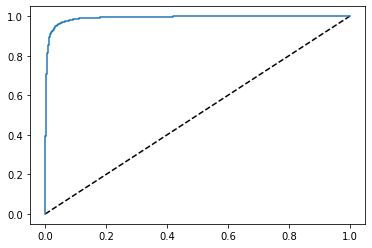

0.9913725504644393


In [24]:
fpr, tpr, _ = roc_curve(y, stepwise_model.predict(sm.add_constant(X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

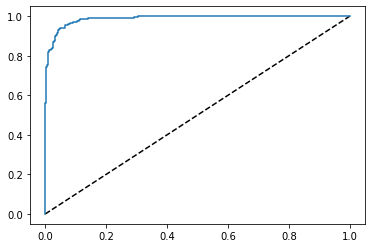

0.988094646627748


In [25]:
fpr, tpr, _ = roc_curve(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

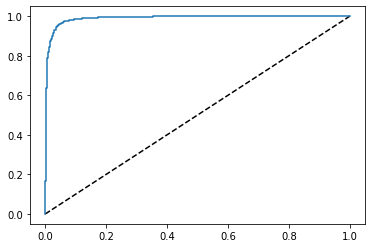

0.989461199863091


In [26]:
fpr, tpr, _ = roc_curve(test_y, stepwise_model.predict(sm.add_constant(test_X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

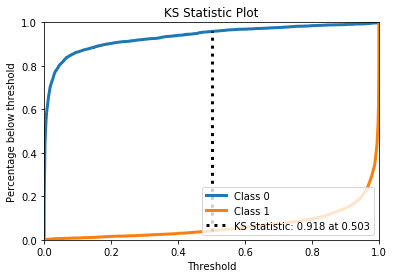

In [27]:
proba = [[1-x, x] for x in stepwise_model.predict(sm.add_constant(X[stepwise_features]))]

plot_ks_statistic(y, proba)
plt.show()

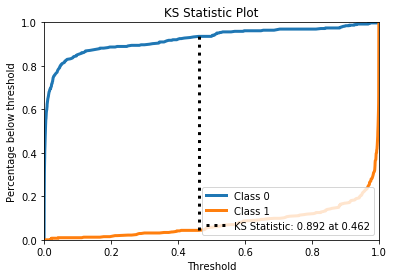

In [28]:
proba = [[1-x, x] for x in stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))]

plot_ks_statistic(validate_y, proba)
plt.show()

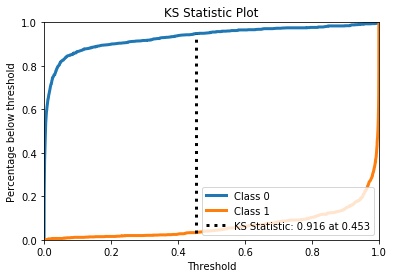

In [29]:
proba = [[1-x, x] for x in stepwise_model.predict(sm.add_constant(test_X[stepwise_features]))]

plot_ks_statistic(test_y, proba)
plt.show()

In [30]:
result = pd.DataFrame({'AUC': [roc_auc_score(y, stepwise_model.predict(sm.add_constant(X[stepwise_features]))),
                               roc_auc_score(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))),
                               roc_auc_score(test_y, stepwise_model.predict(sm.add_constant(test_X[stepwise_features])))],
                       'KS Statistic': [0.918, 0.892, 0.916],
                       'Accuracy': [accuracy_score(y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(X[stepwise_features]))]),
                                    accuracy_score(validate_y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))]),
                                    accuracy_score(test_y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(test_X[stepwise_features]))])]})
result.index = ['Train', 'Validate', 'Test']
result

,AUC,KS Statistic,Accuracy
Train,0.991373,0.918,0.958997
Validate,0.988095,0.892,0.941469
Test,0.989461,0.916,0.956132


In [31]:
confusion_matrix(y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(X[stepwise_features]))])

array([[3444,  148],
       [ 148, 3479]], dtype=int64)

In [32]:
confusion_matrix(validate_y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))])

array([[365,  23],
       [ 24, 391]], dtype=int64)

In [33]:
confusion_matrix(test_y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(test_X[stepwise_features]))])

array([[987,  47],
       [ 41, 931]], dtype=int64)

# Model Evaluation

In [34]:
X = data.drop('Win', axis = 1)
y = data['Win']

In [35]:
stepwise_features = stepwise_regression(X, y)
stepwise_features

['Tower_Destroyed',
 'Total_Deaths',
 'Game_Duration',
 'Baron_Killed',
 'Total_Champion_Level',
 'Inhibitor_Destroyed',
 'Dragon_Killed',
 'Total_Magic_Damage_To_Champions',
 'Total_Neutral_Minions_Killed',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Vision_Score',
 'Total_Physical_Damage_To_Champions',
 'Total_Neutral_Minions_Killed_Enemy_Jungle',
 'First_Tower',
 'Total_Time_CCing_Others',
 'Total_True_Damage_To_Champions',
 'Total_Physical_Damage_Taken',
 'Total_Magical_Damage_Taken',
 'Total_Heal',
 'Total_Damage_Dealt_To_Turrets',
 'First_Dragon',
 'Total_Kills']

In [36]:
model = sm.GLM(y, sm.add_constant(X[stepwise_features]), family = sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                10028
Model:                            GLM   Df Residuals:                    10004
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1191.2
Date:                Sun, 14 Feb 2021   Deviance:                       2382.3
Time:                        21:28:19   Pearson chi2:                 3.46e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.1640      0.212     -5.499      0.000      -1.579      -0.749
Tower_Destroyed                               0.6034      0.062      9.697      0.000       0.481       0.725
Total_Deaths                                 -0.2568      0.012    -22.245      0.000      -0.279      -0.234
Game_Duration                                -0.0099      0.001    -15.594      0.000      -0.011      -0.009
Baron_Killed                                  0.2627      0.133      1.976      0.048       0.002       0.523
Total_Champion_Level                          0.1709      0.015     11.216      0.000       0.141       0.201
Inhibitor_Destroyed                           0.6841      0.087      7.863      0.000       0.514       0.855
Dragon_Killed                                 0.4672      0.068      6.827      0.000       0.333       0.601
Total_Magic_Damage_To_Champions            4.135e-05   5.05e-06      8.192      0.000    3.15e-05    5.12e-05
Total_Neutral_Minions_Killed                 -0.0112      0.002     -4.703      0.000      -0.016      -0.007
Total_Gold_Earned                             0.0004   3.91e-05      9.808      0.000       0.000       0.000
Total_Minions_Killed                         -0.0109      0.001     -7.752      0.000      -0.014      -0.008
Total_Vision_Score                           -0.0117      0.002     -4.889      0.000      -0.016      -0.007
Total_Physical_Damage_To_Champions         3.081e-05   5.71e-06      5.395      0.000    1.96e-05     4.2e-05
Total_Neutral_Minions_Killed_Enemy_Jungle    -0.0138      0.006     -2.348      0.019      -0.025      -0.002
First_Tower                                   0.3635      0.121      3.011      0.003       0.127       0.600
Total_Time_CCing_Others                      -0.0040      0.001     -2.928      0.003      -0.007      -0.001
Total_True_Damage_To_Champions             3.298e-05   1.43e-05      2.313      0.021    5.03e-06    6.09e-05
Total_Physical_Damage_Taken               -3.732e-05   5.57e-06     -6.698      0.000   -4.82e-05   -2.64e-05
Total_Magical_Damage_Taken                 -2.93e-05   5.25e-06     -5.577      0.000   -3.96e-05    -1.9e-05
Total_Heal                                 2.114e-05    6.8e-06      3.107      0.002    7.81e-06    3.45e-05
Total_Damage_Dealt_To_Turrets             -3.707e-05   2.08e-05     -1.779      0.075   -7.79e-05    3.77e-06
First_Dragon                                 -0.2216      0.137     -1.623      0.105      -0.489       0.046
Total_Kills                                  -0.0262      0.017     -1.497      0.134      -0.060       0.008
=============================================================================================================
"""

In [37]:
critical_value = stats.chi2.ppf(0.95, df=model.df_resid)
p_value = stats.chi2.sf(model.deviance, df=model.df_resid)

print('Test statistic:', model.deviance)
print('Critical value:', critical_value)
print('p-value:', p_value)

Test statistic: 2382.3012225223274
Critical value: 10237.795417627163
p-value: 1.0


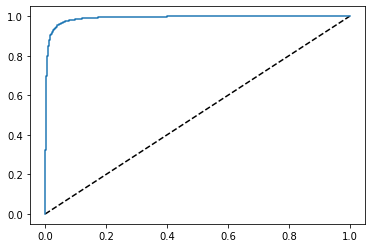

0.9908789096155018


In [38]:
fpr, tpr, _ = roc_curve(y, model.predict(sm.add_constant(X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

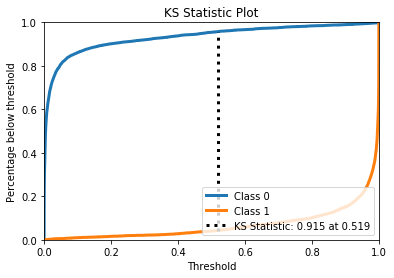

In [39]:
proba = [[1-x, x] for x in model.predict(sm.add_constant(X[stepwise_features]))]

plot_ks_statistic(y, proba)
plt.show()

In [40]:
accuracy_score(y, [1 if prob >= 0.519 else 0 for prob in model.predict(sm.add_constant(X[stepwise_features]))])

0.9574192261667331

In [41]:
confusion_matrix(y, [1 if prob >= 0.519 else 0 for prob in model.predict(sm.add_constant(X[stepwise_features]))])

array([[4801,  213],
       [ 214, 4800]], dtype=int64)

In [42]:
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X[stepwise_features]).values, i) for i in range(X[stepwise_features].shape[1] + 1)]
vif['feature'] = sm.add_constant(X[stepwise_features]).columns
vif.drop(0).sort_values('vif', ascending = False).head(10)

,vif,feature
10,146.354749,Total_Gold_Earned
3,30.894150,Game_Duration
5,22.436569,Total_Champion_Level
23,22.181555,Total_Kills
1,15.107261,Tower_Destroyed
11,14.112677,Total_Minions_Killed
18,11.433888,Total_Physical_Damage_Taken
21,9.155612,Total_Damage_Dealt_To_Turrets
13,7.306033,Total_Physical_Damage_To_Champions
2,7.251173,Total_Deaths


In [43]:
X[stepwise_features].corr()['Total_Gold_Earned'].abs().sort_values(ascending = False).head(10)
# Total_Gold_Earned is much correlated to other variables, e.g. Total_Champion_Level, Game_Duration

Total_Gold_Earned                     1.000000
Total_Champion_Level                  0.960307
Game_Duration                         0.933739
Total_Kills                           0.888698
Total_Minions_Killed                  0.883357
Total_Physical_Damage_Taken           0.820507
Total_Physical_Damage_To_Champions    0.815863
Total_Vision_Score                    0.804874
Total_Heal                            0.804561
Total_Neutral_Minions_Killed          0.792801
Name: Total_Gold_Earned, dtype: float64

In [44]:
new_stepwise_features = stepwise_features.copy()
new_stepwise_features.remove('Total_Gold_Earned')

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X[new_stepwise_features]).values, i) for i in range(X[new_stepwise_features].shape[1] + 1)]
vif['feature'] = sm.add_constant(X[new_stepwise_features]).columns
vif.drop(0).sort_values('vif', ascending = False).head(10)

,vif,feature
5,22.321736,Total_Champion_Level
3,21.058586,Game_Duration
1,14.620686,Tower_Destroyed
17,11.416902,Total_Physical_Damage_Taken
22,9.213239,Total_Kills
20,8.971131,Total_Damage_Dealt_To_Turrets
10,8.065493,Total_Minions_Killed
12,7.121898,Total_Physical_Damage_To_Champions
2,6.815803,Total_Deaths
18,6.087689,Total_Magical_Damage_Taken


In [45]:
reduced_model = sm.GLM(y, sm.add_constant(X[new_stepwise_features]), family = sm.families.Binomial()).fit()
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                10028
Model:                            GLM   Df Residuals:                    10005
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1242.3
Date:                Sun, 14 Feb 2021   Deviance:                       2484.7
Time:                        21:28:21   Pearson chi2:                 2.21e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -0.7404      0.205     -3.609      0.000      -1.142      -0.338
Tower_Destroyed                               0.7275      0.061     11.980      0.000       0.608       0.846
Total_Deaths                                 -0.2260      0.011    -21.334      0.000      -0.247      -0.205
Game_Duration                                -0.0063      0.000    -12.760      0.000      -0.007      -0.005
Baron_Killed                                  0.9256      0.116      7.959      0.000       0.698       1.154
Total_Champion_Level                          0.1780      0.015     11.873      0.000       0.149       0.207
Inhibitor_Destroyed                           0.6879      0.085      8.085      0.000       0.521       0.855
Dragon_Killed                                 0.4500      0.067      6.738      0.000       0.319       0.581
Total_Magic_Damage_To_Champions            4.622e-05   4.94e-06      9.361      0.000    3.65e-05    5.59e-05
Total_Neutral_Minions_Killed                 -0.0041      0.002     -1.849      0.064      -0.008       0.000
Total_Minions_Killed                         -0.0017      0.001     -1.665      0.096      -0.004       0.000
Total_Vision_Score                           -0.0070      0.002     -2.996      0.003      -0.012      -0.002
Total_Physical_Damage_To_Champions          3.82e-05   5.51e-06      6.936      0.000    2.74e-05     4.9e-05
Total_Neutral_Minions_Killed_Enemy_Jungle    -0.0180      0.006     -3.151      0.002      -0.029      -0.007
First_Tower                                   0.3272      0.118      2.768      0.006       0.096       0.559
Total_Time_CCing_Others                      -0.0032      0.001     -2.389      0.017      -0.006      -0.001
Total_True_Damage_To_Champions              5.01e-05   1.38e-05      3.628      0.000     2.3e-05    7.72e-05
Total_Physical_Damage_Taken               -3.572e-05   5.37e-06     -6.655      0.000   -4.62e-05   -2.52e-05
Total_Magical_Damage_Taken                -3.022e-05    5.1e-06     -5.930      0.000   -4.02e-05   -2.02e-05
Total_Heal                                 2.932e-05   6.64e-06      4.414      0.000    1.63e-05    4.23e-05
Total_Damage_Dealt_To_Turrets             -1.635e-05   2.04e-05     -0.803      0.422   -5.62e-05    2.35e-05
First_Dragon                                 -0.2761      0.134     -2.060      0.039      -0.539      -0.013
Total_Kills                                   0.1110      0.011     10.146      0.000       0.090       0.132
=============================================================================================================
"""

In [46]:
test_statistic = 2*(reduced_model.deviance - model.deviance)
critical_value = stats.chi2.ppf(0.95, df=1)
p_value = stats.chi2.sf(test_statistic, df=1)

print('Test statistic:', test_statistic)
print('Critical value:', critical_value)
print('p-value:', p_value)
# To reduce the significance of collinearity problem, the deviance increases signficantly. 
# Thus, we do not drop Total_Gold_Earned

Test statistic: 204.7197322760003
Critical value: 3.841458820694124
p-value: 1.9495710617752814e-46


# Conclusion

1. From the final model, we can see that 15 factors (e.g. Total Assist) are not significant to the win rate. For example, before the jungler of a team ganks a lane, the laner(s) of that team may start action first. Sometimes, the laner(s) may be able to kill the opposite laner(s) without the help of the jungler. In this case, the laner(s) may not need to wait for the jungler to come and participate if it makes the kill become more difficult.
2. From the final model, we can interpret how the significant factors affecting the odd ratio. Interestingly, for example, we have 95\% confidence that 10 second increase in time CCing others will be associated with from 1.00\% to 5.82\% decrease in the odd ratio. This suggest that when we are picking champions, we should less consider the champions with crowd control ability.

# Problems

1. There is a significant collinearity problem. We tried to drop the most correlated variable, Total money earned, but it makes the deviance increase a lot. The significant collinearity problem makes the standard error become too large.
2. In the game setting, some variables in nature affect each other. For example, getting the first tower will award extra money to the team. In this case, when interpreting the odd ratio, we may need to consider the effect of the extra money.

# Further Work

1. The analysis needs to be frequently updated as the patch will frequently change. The factors affecting the win rate will also change.
2. The analysis focus on the team aspect. In the future, we can try to analyze the win rate in individual aspect.
3. The analysis is about unrank games. We can also try to analyze high elo games in the future.